# Taxi Demand Prediction - Neural Network
---
In this notebook, we build a model for predicting taxi demand in Chicago. The model is based on the information provided by the city of Chicago in 2015. 

Furthermore, the model is based on all of the available data. Since we use mini batches to train the neural network and the prediction target is taxi demand which is calculated by data aggregation. We won't encounter any memory problems. 

To build our demand prediction model, we proceed as following:

- Data prepration
- Adding spatial and temporal features
- Preprocessing and scaling
- Finding NN architecture in an iterative process
- Model building (with different spatial attributes)
- Tuning the hyperparameters of the final architecture for each model (daily, 6H, and hourly)
- Model evaluations
- Result Analysis
- Conclusion and outlook


In [1]:
cd ..

C:\Users\Sepehr\Desktop\Master\AdvanceAnalyticsAndApps\project\aaa21\aaa21


In [2]:
import utils, feature_engineering, geo_engineering,preprocessing,prediction_nn,prediction_utils
import pandas as pd
import numpy as np
import geopandas
from fastai.tabular.all import *
import matplotlib.pyplot as plt
%matplotlib inline

# Daily Models
---
To help taxi companies prepare for daily demand in different part of the city we build a daily demand predictin model using neural networks. This model will help the cab industry to better utilize its resources and is also beneficial for mid-long term planning. The model is based on the 2015 inforamtion.

**Model input:**
- Geographical area where the customer is expected
- Date 
- Weather Information

**Model output:**
- Demand for the given date at the given area

## Data Preparation
---
First we aggregate and prepare our data for modeling.

In [3]:
# Takes few minutes to run (16 GB RAM)
chicago_df = utils.read_parquet('Taxi_Trips_Cleaned.parquet', 
                                columns=['Trip ID','Trip Start Timestamp','Pickup Community Area',
                                         'Dropoff Community Area'])
weather_df = utils.read_parquet('Weather.parquet',columns = ['Trip Start Timestamp','Humidity(%)',
                                    'Pressure(hPa)','Temperature(C)',
                                    'Wind Direction(Meteoro. Degree)','Wind Speed(M/S)'])

daily_demand = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D')
daily_demand_hex_7 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D',
                                            use_hexes=True,hex_resolution=7)
daily_demand_hex_6 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D',
                                            use_hexes=True,hex_resolution=6)

del chicago_df
del weather_df

### Feature Engineering
---
In this section we add the following spatial and temporal features to our data before prediction.
- Distance to Chicago City Center
- Distance to Chicago Airport
- Holiday Events

In [4]:
#Spatial Features
daily_demand = feature_engineering.add_spatial_features(daily_demand)
daily_demand_hex_7 = feature_engineering.add_spatial_features(daily_demand_hex_7,with_hex=7,hex_res=7)
daily_demand_hex_6 = feature_engineering.add_spatial_features(daily_demand_hex_6,with_hex=6,hex_res=6)
#Holidays
daily_demand = feature_engineering.add_holidays(daily_demand)
daily_demand_hex_6 = feature_engineering.add_holidays(daily_demand_hex_6)
daily_demand_hex_7 = feature_engineering.add_holidays(daily_demand_hex_7)

### Daily Model - Community Areas
---
In this section we build our nn model for demand prediction using community areas as our geographical attributes. we build different models and opt for the final model by comparing the overall evaluation metrics.

### Model Architecture
---
To gain a better understanding of our data and the amount of complexity needed in the nn architecture we first start our daily model by a simple 50 * 25 structure. After observing the behavoiur of the model we adjust the layer structure. First by adding/removing nodes , Second by increasing/decreasing the number of hidden layers of the network. For the sake of brevity this notebook does not show all tested nn architectures.

_Note: This was an iterative process. We didn't use brut force algorithms to search for the optimal structure on a grid as it is not computationaly feasible._

### Suitable Metrics
---
To gain a better understanding which metrics we should apply to our problem we plot the prediction target to identify the distribution type.

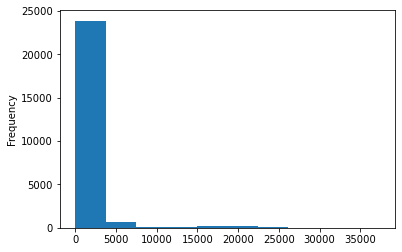

In [5]:
daily_demand['Demand (D)'].plot.hist()
plt.show()

As we expected the target is extremely skewed. Which would make the prediction metrics non telling. To tackle this obstacle, we transform the target logarithmically. And use the mean squared logarithmic error as our metric.

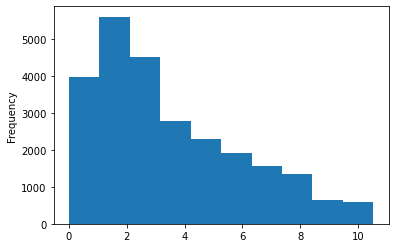

In [6]:
daily_demand['Demand (D)'] = np.log(daily_demand['Demand (D)'])
daily_demand['Demand (D)'].plot.hist()
plt.show()

In [5]:
#Train - Test - Validation Split
train_val_dls,test_dl = prediction_nn.split_data_sets_for_nn(daily_demand,temporal_resolution='D',
                                                test_size=0.2,batch_size=256,validation_size=0.2)

In [11]:
#Augmented data
train_val_dls.items.head(5)

,Pickup Community Area,Demand (D),Week,Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,6.006353,1,1.482632,0.603238,-1.074596,0.827205,3.182126,0.559626,-0.923707,...,1,4,1,1,2,1,2,1,2,-1.717805
1,2,3.465736,1,1.482632,0.603238,-1.074596,0.827205,3.182126,1.348968,-1.761134,...,1,4,1,1,2,1,2,1,2,-1.717805
2,3,4.290460,1,1.482632,0.603238,-1.074596,0.827205,3.182126,0.864702,-1.476916,...,1,4,1,1,2,1,2,1,2,-1.717805
3,4,2.708050,1,1.482632,0.603238,-1.074596,0.827205,3.182126,0.947332,-1.481991,...,1,4,1,1,2,1,2,1,2,-1.717805
4,5,3.663562,1,1.482632,0.603238,-1.074596,0.827205,3.182126,0.426499,-1.152096,...,1,4,1,1,2,1,2,1,2,-1.717805


In [15]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(train_val_dls.cont_names)
print('\nCategorical variables:')
print(train_val_dls.cat_names)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['Pickup Community Area', 'Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Dayofyear', 'Week']


#### First Iteretation - NN Architecture
---
- Network architecture: 50 - 25
- Without regularization

In [85]:
#Config Profile
y_range = [daily_demand['Demand (D)'].min(),daily_demand['Demand (D)'].max()*1.1]
naive_config = tabular_config(y_range=y_range)
daily_model_naive = tabular_learner(train_val_dls, layers=[50,25],config=naive_config,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True)

In [86]:
daily_model_naive.summary()

TabularModel (Input shape: 256 x torch.Size([256, 8]))
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 18            
Embedding                                 1404       True      
____________________________________________________________________________
                     256 x 3             
Embedding                                 9          True      
____________________________________________________________________________
                     256 x 2             
Embedding                                 4          True      
____________________________________________________________________________
                     256 x 5             
Embedding                                 45         True      
____________________________________________________________________________
                     256 x 11            
Embedding                                 352        True      
___________________________________________

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,2.146890,1.328093,0.160431,2.677240,00:02
1,0.681459,0.629751,0.064226,1.651993,00:02
2,0.359668,0.604972,0.061666,1.699850,00:02
3,0.274773,0.560206,0.061426,1.554182,00:02
4,0.240563,0.505040,0.056331,1.336573,00:02
5,0.220339,0.477685,0.053972,1.375782,00:02
6,0.216134,0.425914,0.051425,1.110116,00:02
7,0.208127,0.360483,0.049013,0.955437,00:02
8,0.204352,0.315991,0.046897,0.799780,00:02
9,0.197347,0.321322,0.048477,0.811751,00:02


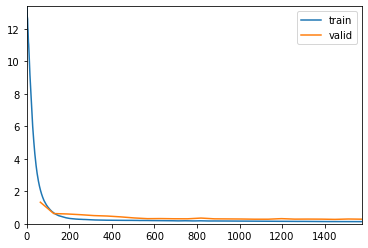

In [87]:
daily_model_naive.fit(25,cbs=[ShowGraphCallback()])

#### First Iteration Evaluation
---
To get the result for our first nn architecture we use the test set for evaluation.

In [88]:
prediction = daily_model_naive.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  53.429 %
sMAPE:  40.750 %
MAE:  260.658
MSE:  978932.750
RMSE:  989.410
R2:  88.666 %
Max Residual Error:  19154.498


The above shows the result of our first model. We see that the model suffers from overfitting. Thus we reduce the number of Nodes in each layer.

#### Second Iteration
---
NN Architecture:
- Network architecture: 15 - 15
- Without Regularization

In [77]:
daily_model_iter2 = tabular_learner(train_val_dls, layers=[15,15],config=naive_config,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True)

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,11.637662,11.933719,1.174399,0.860665,00:02
1,4.593472,1.273817,0.227896,0.764877,00:02
2,1.714297,0.414621,0.058344,0.556530,00:02
3,0.705414,0.604121,0.060853,0.657445,00:02
4,0.413741,0.253795,0.044937,0.634506,00:02
5,0.328649,0.262845,0.046229,0.709595,00:02
6,0.300611,0.292912,0.046072,0.660040,00:02
7,0.284404,0.689324,0.062465,0.723887,00:02
8,0.278075,0.231575,0.043905,0.607610,00:02
9,0.283203,0.240371,0.045354,0.640459,00:02


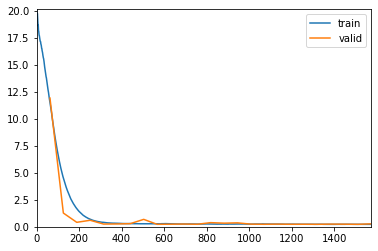

In [78]:
daily_model_iter2.fit(25,cbs=[ShowGraphCallback()])

#### Second Iteration - Evaluation
---
We evaluate our second daily model using the test set.

In [79]:
prediction = daily_model_iter2.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  44.704 %
sMAPE:  40.116 %
MAE:  318.786
MSE:  1920098.750
RMSE:  1385.676
R2:  77.770 %
Max Residual Error:  16806.934


Removing 10 nodes from each layer did not improve our model. The model bias has increased. The MAPE metric has improved but now the R2 score has dropped and the MAE and maximal error has increased significantly.

### Third Iteration- Network Architecture
---
Now we introduce more hidden layer to capture more of the complexity. To Reduce the Bias of the previous model.
- Network Architecture: 15 - 15 - 10 
- Without regularization

In [82]:
daily_model_iter3 = tabular_learner(train_val_dls, layers=[15,15,10],config=naive_config,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True)

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,15.013178,13.806401,1.137361,0.838226,00:02
1,9.689160,5.298569,0.385430,0.789093,00:02
2,4.557240,1.089681,0.122376,0.634553,00:02
3,1.658048,0.264378,0.046478,0.576666,00:02
4,0.659806,0.271702,0.048949,0.703432,00:02
5,0.400173,0.266382,0.046522,0.708781,00:02
6,0.308724,0.266617,0.050871,0.716886,00:02
7,0.294741,0.250927,0.047285,0.609594,00:02
8,0.289509,0.260572,0.048740,0.577448,00:02
9,0.277445,0.257088,0.046330,0.618389,00:02


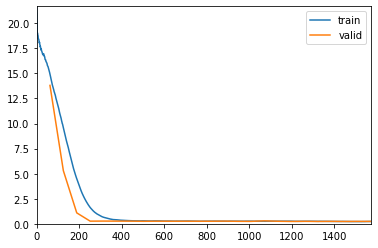

In [83]:
daily_model_iter3.fit(25,cbs=[ShowGraphCallback()])

The validation loss is steady and the training loss decreased monotonously. We however anticipate that our model has still overfitting problem. Thus we calculate the metrics using our test set.

#### Third Iteration - Evaluation
---

In [84]:
prediction = daily_model_iter3.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  372.087 %
sMAPE:  40.850 %
MAE:  7236.063
MSE:  50570620928.000
RMSE:  224879.125
R2: -585390.157 %
Max Residual Error:  11329998.000


As Expected now our model has overfitted to the training data dramatically and the result are worse than other approaches.

**We use the NN architecture in the first iteration and now try to introduce regularization to help the network overcome the overfitting problem.**

#### Hyper Parameter Tuning
---
We tune the following hyper parameters to avoid overfitting:
- Learning rate
- Weight Decay
- Momentum
- Dropout for embeddings layers
- Dropout probabilites

We also introduce early stopping in our network

#### Suitable learning rate
---
To find the best learning rate we make use of the lr_find function of the fast ai library. For in depth information please refer to this paper: 
_Cyclical Learning Rates for Training Neural Networks by Leslie N. Smith_

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=7.585775847473997e-07)

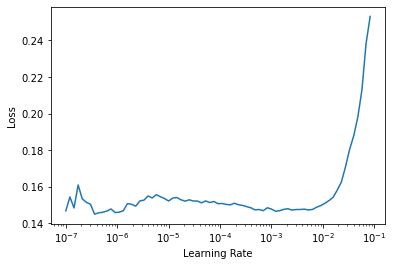

In [89]:
daily_model_final.lr_find()

_The plot shows that the default 0.001 lr is a good option for the final model._

#### Daily Model - Final
---
The Following shows the final daily model configurations:
- NN Architecture: 50 x 25
- L2 Reg : 0.001
- Embedding Dropout Probability: 4%
- Continous Dropout Probability: 0.01% in the first layer and 1% in the second layer
- Learning rate: 0.001
- Momentum: 0.95 - 0.85 - 0.95 (adaptive)
- Batch Normalization for input/Hidden layers
- Loss Function: MSE
- Target: Logarithmic Daily Demand
- Early Stopping: If no imporvement better than 0.01 (after maximum 5 epochs)

In [16]:
#Config Profile
y_range = [daily_demand['Demand (D)'].min(),daily_demand['Demand (D)'].max()*1.1]
config_final = tabular_config(ps=[0.001,0.01], embed_p=0.04, y_range=y_range, use_bn=True, 
               bn_final=False, bn_cont=True)
daily_model_final = tabular_learner(train_val_dls, layers=[50,25],config=config_final,wd=0.001,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True, moms=(0.95, 0.85, 0.95))

In [18]:
#Our final daily model config
daily_model_final.summary()

TabularModel (Input shape: 256 x torch.Size([256, 8]))
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 18            
Embedding                                 1404       True      
____________________________________________________________________________
                     256 x 3             
Embedding                                 9          True      
____________________________________________________________________________
                     256 x 2             
Embedding                                 4          True      
____________________________________________________________________________
                     256 x 5             
Embedding                                 45         True      
____________________________________________________________________________
                     256 x 11            
Embedding                                 352        True      
___________________________________________

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,1.922585,3.431005,0.318188,8.466949,00:02
1,0.643640,0.806865,0.075364,2.251414,00:02
2,0.369936,0.591431,0.062496,1.733346,00:02
3,0.292635,0.553761,0.061863,1.518107,00:02
4,0.268244,0.437513,0.055495,1.227699,00:02
5,0.248520,0.443710,0.054215,1.232950,00:02
6,0.236498,0.364855,0.050950,0.978697,00:02
7,0.232194,0.325041,0.050130,0.919069,00:02
8,0.226549,0.291244,0.047008,0.737734,00:02
9,0.222948,0.288857,0.046185,0.741676,00:02


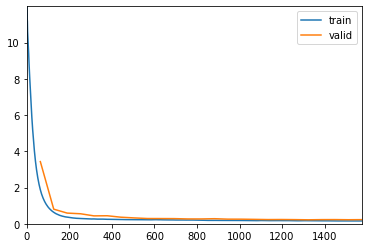

In [68]:
daily_model_final.fit(25,cbs=[ShowGraphCallback(),
                              EarlyStoppingCallback(monitor='valid_loss', 
                              min_delta=0.01, patience=5, reset_on_fit=True)])

In [69]:
prediction = daily_model_final.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  38.078 %
sMAPE:  33.982 %
MAE:  181.011
MSE:  587015.875
RMSE:  766.170
R2:  93.204 %
Max Residual Error:  12184.105


After applying regularization the tendency of our model for overfitting has decreased significantly thus improving the overall metrics.
Most importantly the validation loss has become steady.

### Daily Model - Hex 7
---
After finding the suitable model architecture for our daily demand prediction we change the geographic predictors from community areas to hexes with resolution 7. After training the model we compare the results with the community area model.

In [19]:
#Log transformation
daily_demand_hex_7['Demand (D)'] = np.log(daily_demand_hex_7['Demand (D)'])

In [20]:
#Train - Test - Validation Split
train_val_dls,test_dl = prediction_nn.split_data_sets_for_nn(daily_demand_hex_7,temporal_resolution='D',
                                                test_size=0.2,batch_size=256,validation_size=0.2)

In [21]:
# Augmented data
train_val_dls.items.head(5)

,hex_7_pickup,Demand (D),Week,Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,0.000000,1,1.482259,0.60394,-1.075434,0.827946,3.181142,2.659395,2.589471,...,1,4,1,1,2,1,2,1,2,-1.717593
1,2,0.693147,1,1.482259,0.60394,-1.075434,0.827946,3.181142,1.828572,2.089833,...,1,4,1,1,2,1,2,1,2,-1.717593
2,4,6.493754,1,1.482259,0.60394,-1.075434,0.827946,3.181142,0.790386,-0.024021,...,1,4,1,1,2,1,2,1,2,-1.717593
3,5,1.098612,1,1.482259,0.60394,-1.075434,0.827946,3.181142,0.762373,0.225798,...,1,4,1,1,2,1,2,1,2,-1.717593
4,6,0.000000,1,1.482259,0.60394,-1.075434,0.827946,3.181142,0.808937,0.475617,...,1,4,1,1,2,1,2,1,2,-1.717593


In [22]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(train_val_dls.cont_names)
print('\nCategorical variables:')
print(train_val_dls.cat_names)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Dayofyear', 'Week', 'hex_7_pickup']


We use the final config obtained in daily model with community areas to be able to compare the results.

In [8]:
#Config Profile
y_range = [daily_demand_hex_7['Demand (D)'].min(),daily_demand_hex_7['Demand (D)'].max()*1.1]
config_final = tabular_config(ps=[0.001,0.01], embed_p=0.04, y_range=y_range, use_bn=True, 
               bn_final=False, bn_cont=True)
daily_model_final_with_hex7 = tabular_learner(train_val_dls, layers=[50,25],config=config_final,wd=0.001,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True, moms=(0.95, 0.85, 0.95))

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,1.208618,1.592471,0.145740,2.536178,00:02
1,0.479413,0.289403,0.047921,0.809473,00:02
2,0.308604,0.256002,0.044905,0.770700,00:02
3,0.266745,0.246423,0.044232,0.698365,00:02
4,0.241145,0.286765,0.046007,0.748159,00:02
5,0.236649,0.258534,0.044170,0.720497,00:02
6,0.226840,0.234546,0.043259,0.615443,00:02
7,0.214663,0.234352,0.043109,0.610904,00:02
8,0.209265,0.246509,0.043457,0.645147,00:02
9,0.201845,0.234746,0.043119,0.651076,00:02


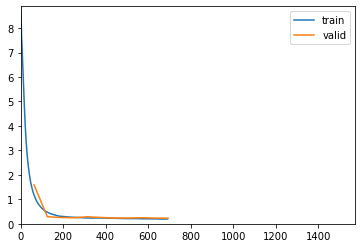

No improvement since epoch 6: early stopping


In [9]:
daily_model_final_with_hex7.fit(25,cbs=[ShowGraphCallback(),
                              EarlyStoppingCallback(monitor='valid_loss', 
                              min_delta=0.01, patience=5, reset_on_fit=True)])

In [10]:
prediction = daily_model_final_with_hex7.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  39.643 %
sMAPE:  35.468 %
MAE:  204.953
MSE:  787777.375
RMSE:  887.568
R2:  90.737 %
Max Residual Error:  17869.430


As expected we observe similar results as in the community area model. Since Hex 7 resolution covers roughly the same areas as community areas in Chicago. 

**Conculusion: Using Hex 7 geo attributes delivers similar result as using community areas**

### Daily Model - Hex 6
---
Lastly we change the geographic predictors from community areas to hexes with resolution 6. After training the model we compare the results with the community area model. Contrary to the hex 7 model we expect our result to change since the hex 6 resolution covers much bigger geographical areas.

In [23]:
#Log transformation
daily_demand_hex_6['Demand (D)'] = np.log(daily_demand_hex_6['Demand (D)'])

In [24]:
#Train - Test - Validation Split
train_val_dls,test_dl = prediction_nn.split_data_sets_for_nn(daily_demand_hex_6,temporal_resolution='D',
                                                test_size=0.2,batch_size=256,validation_size=0.2)

In [25]:
# Augmented data
train_val_dls.items.head(5)

,hex_6_pickup,Demand (D),Week,Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,1.098612,1,1.482058,0.610629,-1.082438,0.832635,3.185211,2.043690,1.827465,...,1,4,1,1,2,1,2,1,2,-1.721428
1,1,1.098612,1,1.482058,0.610629,-1.082438,0.832635,3.185211,2.043690,1.827465,...,1,4,1,1,2,1,2,1,2,-1.721428
2,3,6.498282,1,1.482058,0.610629,-1.082438,0.832635,3.185211,0.670191,0.686459,...,1,4,1,1,2,1,2,1,2,-1.721428
3,3,6.498282,1,1.482058,0.610629,-1.082438,0.832635,3.185211,0.670191,0.686459,...,1,4,1,1,2,1,2,1,2,-1.721428
4,4,1.386294,1,1.482058,0.610629,-1.082438,0.832635,3.185211,1.103955,0.962434,...,1,4,1,1,2,1,2,1,2,-1.721428


In [26]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(train_val_dls.cont_names)
print('\nCategorical variables:')
print(train_val_dls.cat_names)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['hex_6_pickup', 'Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Dayofyear', 'Week']


We use the final config obtained in daily model with community areas to be able to compare the results.

In [26]:
#Config Profile
y_range = [daily_demand_hex_6['Demand (D)'].min(),daily_demand_hex_6['Demand (D)'].max()*1.1]
config_final = tabular_config(ps=[0.01,0.01], embed_p=0.04, y_range=y_range, use_bn=True, 
               bn_final=False, bn_cont=True)
daily_model_final_with_hex6 = tabular_learner(train_val_dls, layers=[50,25],config=config_final,wd=0.001,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True, moms=(0.95, 0.85, 0.95))

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,0.985169,1.303148,0.077399,3.024603,00:02
1,0.366694,0.351270,0.022425,1.047142,00:02
2,0.226222,0.250702,0.019558,0.821792,00:02
3,0.182756,0.218855,0.017703,0.719563,00:02
4,0.169905,0.180467,0.016205,0.545619,00:02
5,0.147656,0.192203,0.016950,0.536533,00:02
6,0.134030,0.163935,0.015982,0.568867,00:02
7,0.126564,0.169750,0.016010,0.481189,00:02
8,0.125191,0.168612,0.016241,0.459428,00:02
9,0.115889,0.182596,0.016472,0.550989,00:02


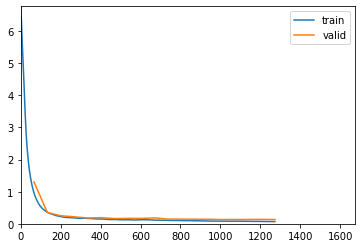

No improvement since epoch 14: early stopping


In [27]:
daily_model_final_with_hex6.fit(25,cbs=[ShowGraphCallback(),
                              EarlyStoppingCallback(monitor='valid_loss', 
                              min_delta=0.01, patience=5, reset_on_fit=True)])

In [28]:
prediction = daily_model_final_with_hex6.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  34.777 %
sMAPE:  27.751 %
MAE:  528.164
MSE:  4100764.000
RMSE:  2025.034
R2:  91.289 %
Max Residual Error:  32912.379


We see that using a bigger geographical areas led our model to generelize better. We should look only at the relative metrics (MAPE and sMAPE) since the absolute metrics increase regardless of how good the model performs, the reason being the increase in the aggregated demand in each hexagon in the underlying data.

**Conculusion: Using Hex 6 geo attributes delivers slightly better result as using community areas**

In [27]:
#Memory Cleaning
del daily_demand
del daily_demand_hex_6
del daily_demand_hex_7

# 6H Models
---
To help taxi companies prepare for the demand variation in one day in different part of the city we build a demand prediction model for every six hours using neural networks. This model will help the cab industry to better utilize its resources within a day and is also beneficial for mid-short term planning. The model is based on the 2015 inforamtion.

**Model input:**
- Geographical area where the customer is expected
- Time Buckets (Mornings, Midday, Evening, Night)
- Weather Information

**Model output:**
- Demand for the given time zone at the given area

## Data Preparation
---
First we aggregate and prepare our data for modeling.

In [28]:
# Takes few minutes to run (16 GB RAM)
chicago_df = utils.read_parquet('Taxi_Trips_Cleaned.parquet', 
                                columns=['Trip ID','Trip Start Timestamp','Pickup Community Area',
                                         'Dropoff Community Area'])
weather_df = utils.read_parquet('Weather.parquet',columns = ['Trip Start Timestamp','Humidity(%)',
                                    'Pressure(hPa)','Temperature(C)',
                                    'Wind Direction(Meteoro. Degree)','Wind Speed(M/S)'])

six_hour_demand = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='6H')
six_hour_demand_hex_7 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='6H',
                                            use_hexes=True,hex_resolution=7)
six_hour_demand_hex_6 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='6H',
                                            use_hexes=True,hex_resolution=6)

del chicago_df
del weather_df

### Feature Engineering
---
In this section we add the following spatial and temporal features to our data before prediction.
- Distance to Chicago City Center
- Distance to Chicago Airport
- Holiday Events

In [29]:
#Spatial Features
six_hour_demand = feature_engineering.add_spatial_features(six_hour_demand)
six_hour_demand_hex_7 = feature_engineering.add_spatial_features(six_hour_demand_hex_7,with_hex=7,hex_res=7)
six_hour_demand_hex_6 = feature_engineering.add_spatial_features(six_hour_demand_hex_6,with_hex=6,hex_res=6)
#Holidays
six_hour_demand = feature_engineering.add_holidays(six_hour_demand)
six_hour_demand_hex_6 = feature_engineering.add_holidays(six_hour_demand_hex_6)
six_hour_demand_hex_7 = feature_engineering.add_holidays(six_hour_demand_hex_7)

### 6H Model - Community Areas
---
In this section we build our nn model for demand prediction using community areas as our geographical attributes.

### Model Architecture
---
To gain a better understanding of our data and the amount of complexity needed in the nn architecture we first start our 6H model by the last structure used in our daily models. We also our regularization paramter. After observing the behavoiur of the daily model with our 6H data, we adjust (if necessary) the layer structures of our model. 

_Note: This was an iterative process. We didn't use brut force algorithms to search for the optimal structure on a grid as it is not computationaly feasible._

### Suitable Metrics
---
To gain a better understanding which metrics we should apply to our problem we plot the prediction target to identify the distribution type.

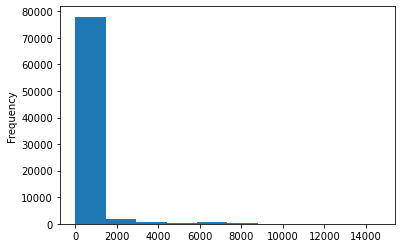

In [32]:
six_hour_demand['Demand (6H)'].plot.hist()
plt.show()

As we expected the target is extremely skewed like the daily model. Which would make the prediction metrics non telling. Thus as before we transform the target logarithmically. And use the mean squared logarithmic error as a metric.

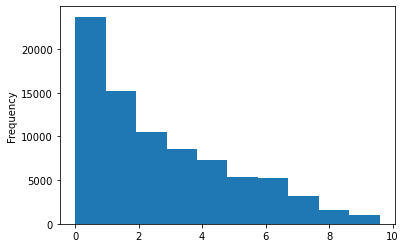

In [33]:
six_hour_demand['Demand (6H)'] = np.log(six_hour_demand['Demand (6H)'])
six_hour_demand['Demand (6H)'].plot.hist()
plt.show()

In [30]:
#Train - Test - Validation Split
train_val_dls,test_dl = prediction_nn.split_data_sets_for_nn(six_hour_demand,temporal_resolution='6H',
                                                test_size=0.2,batch_size=256,validation_size=0.2)

In [31]:
train_val_dls.items.head(5)

,Pickup Community Area,Demand (6H),Week,Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Hour,Elapsed
0,1,252,1,1.324874,0.866174,-1.118566,0.683624,3.0763,0.727766,-1.042581,...,3,234,2,1,2,1,2,1,4,-1.715745
1,2,9,1,1.324874,0.866174,-1.118566,0.683624,3.0763,1.542706,-1.086410,...,3,234,2,1,2,1,2,1,4,-1.715745
2,3,35,1,1.324874,0.866174,-1.118566,0.683624,3.0763,1.042735,-1.071535,...,3,234,2,1,2,1,2,1,4,-1.715745
3,4,3,1,1.324874,0.866174,-1.118566,0.683624,3.0763,1.128045,-1.071800,...,3,234,2,1,2,1,2,1,4,-1.715745
4,5,14,1,1.324874,0.866174,-1.118566,0.683624,3.0763,0.590322,-1.054535,...,3,234,2,1,2,1,2,1,4,-1.715745


In [32]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(train_val_dls.cont_names)
print('\nCategorical variables:')
print(train_val_dls.cat_names)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['Pickup Community Area', 'Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Hour', 'Dayofyear', 'Week']


#### NN Model 6H - First Iteration
---
We first use all of the regularization paramter used in the daily model config (we have checked for the learning rate using the cyclical method as before) and tune them by observing the model behaviour. The Parameters:

- NN Architecture: 50 x 25
- L2 Reg : 0.001
- Embedding Dropout Probability: 4%
- Continous Dropout Probability: 0.01% in the first layer and 1% in the second layer
- Learning rate: 0.001
- Momentum: 0.95 - 0.85 - 0.95 (adaptive)
- Batch Normalization for input/Hidden layers
- Loss Function: MSE
- Target: Logarithmic Daily Demand
- Early Stopping: If no imporvement better than 0.01 (after maximum 5 epochs)

In [42]:
#Config Profile
y_range = [six_hour_demand['Demand (6H)'].min(),six_hour_demand['Demand (6H)'].max()*1.1]
config_first_iter = tabular_config(ps=[0.001,0.01], embed_p=0.04, y_range=y_range, use_bn=True, 
               bn_final=False, bn_cont=True)
six_hour_model_first_iter = tabular_learner(train_val_dls, layers=[50,25],config=config_first_iter,wd=0.001,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True, moms=(0.95, 0.85, 0.95))

#### Suitable learning rate
---
To find the best learning rate we make use of the lr_find function of the fast ai library. For in depth information please refer to this paper: 
_Cyclical Learning Rates for Training Neural Networks by Leslie N. Smith_

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=1.5848931980144698e-06)

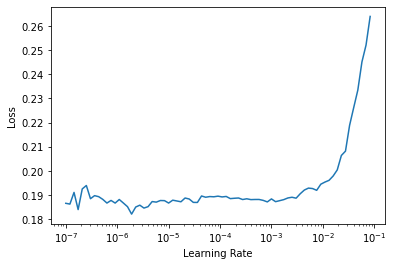

In [47]:
six_hour_model_first_iter.lr_find()

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,0.484848,0.612521,0.092771,1.847026,00:07
1,0.351507,0.396898,0.072516,1.099340,00:07
2,0.314633,0.341995,0.064671,0.900824,00:07
3,0.280432,0.306322,0.064246,0.866908,00:07
4,0.270386,0.278838,0.062962,0.814436,00:07
5,0.258159,0.265997,0.062375,0.751582,00:06
6,0.241038,0.252544,0.061950,0.737230,00:07
7,0.234065,0.260779,0.061443,0.748525,00:07
8,0.230061,0.244837,0.059905,0.689247,00:06
9,0.221795,0.247069,0.060917,0.731322,00:06


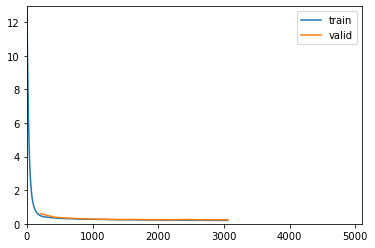

No improvement since epoch 10: early stopping


In [45]:
six_hour_model_first_iter.fit(25,cbs=[ShowGraphCallback(),
                              EarlyStoppingCallback(monitor='valid_loss', 
                              min_delta=0.01, patience=5, reset_on_fit=True)])

In [46]:
prediction = six_hour_model_first_iter.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  57.765 %
sMAPE:  39.414 %
MAE:  75.708
MSE:  111955.672
RMSE:  334.598
R2:  86.731 %
Max Residual Error:  8726.274


The result of our first iteration are already very well. Next we try to improve our model by enabling it to capture more complexity. We also add the embedding dropout probabilities from 4% to 7%. We have tested this model with L2 reg and without and found out that the model perform better without L2 reg.

#### NN Model 6H - Final
---
- Network Architecture: 75 x 50 x 25
- Embedding Dropout Probability: 7%
- Continous Dropout Probability: 0.1% in the first layer and 1% in the hidden layers
- Learning rate: 0.001
- Momentum: 0.95 - 0.85 - 0.95 (adaptive)
- Batch Normalization for input/Hidden layers
- Loss Function: MSE
- Target: Logarithmic Daily Demand
- Early Stopping: If no imporvement better than 0.01 (after maximum 5 epochs)

In [131]:
#Config Profile
y_range = [six_hour_demand['Demand (6H)'].min(),six_hour_demand['Demand (6H)'].max()*1.1]
config_final = tabular_config(ps=[0.001,0.01,0.01], embed_p=0.07, y_range=y_range, use_bn=True, 
               bn_final=False, bn_cont=True)
six_hour_model_final = tabular_learner(train_val_dls, layers=[75,50,25],config=config_final,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True, moms=(0.95, 0.85, 0.95))

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,0.599430,0.494112,0.081662,1.545827,00:07
1,0.347659,0.418026,0.072934,1.156529,00:07
2,0.315063,0.294965,0.063048,0.711654,00:07
3,0.282047,0.286760,0.062711,0.752296,00:07
4,0.261649,0.254117,0.060843,0.619287,00:07
5,0.250686,0.248059,0.060045,0.647602,00:07
6,0.243912,0.250944,0.061084,0.694430,00:07
7,0.238131,0.241987,0.059147,0.612610,00:07
8,0.229718,0.244561,0.059669,0.637171,00:07
9,0.223296,0.237373,0.058868,0.622224,00:07


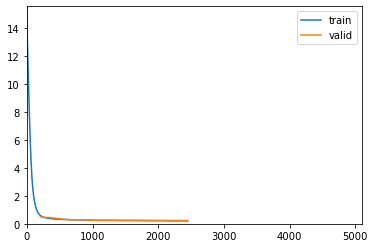

No improvement since epoch 7: early stopping


In [132]:
six_hour_model_final.fit(25,cbs=[ShowGraphCallback(),
                              EarlyStoppingCallback(monitor='valid_loss', 
                              min_delta=0.01, patience=5, reset_on_fit=True)])

In [133]:
prediction = six_hour_model_final.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  49.529 %
sMAPE:  37.098 %
MAE:  69.337
MSE:  90592.172
RMSE:  300.985
R2:  89.263 %
Max Residual Error:  7447.847


As expected the model score has improved by adding a layer of complexity and simultaneously increasing the embedding dropout prababilities.

### 6H Model - Hex 7
---
After finding the suitable model architecture for sin hour demand prediction we change the geographic predictors from community areas to hexes with resolution 7. After training the model we compare the results with the community area model. We expect to observe similiar results like the daily model.

In [33]:
#Log transformation
six_hour_demand_hex_7['Demand (6H)'] = np.log(six_hour_demand_hex_7['Demand (6H)'])

In [34]:
#Train - Test - Validation Split
train_val_dls,test_dl = prediction_nn.split_data_sets_for_nn(six_hour_demand_hex_7,temporal_resolution='6H',
                                                test_size=0.2,batch_size=256,validation_size=0.2)

In [35]:
train_val_dls.items.head(5)

,hex_7_pickup,Demand (6H),Week,Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Hour,Elapsed
0,1,0.000000,1,1.324266,0.867374,-1.119845,0.683938,3.076226,2.897131,-0.870603,...,3,234,2,1,2,1,2,1,4,-1.716123
1,4,2.995732,1,1.324266,0.867374,-1.119845,0.683938,3.076226,0.972748,-1.010475,...,3,234,2,1,2,1,2,1,4,-1.716123
2,6,0.000000,1,1.324266,0.867374,-1.119845,0.683938,3.076226,0.991849,-0.983735,...,3,234,2,1,2,1,2,1,4,-1.716123
3,7,0.000000,1,1.324266,0.867374,-1.119845,0.683938,3.076226,1.113234,-0.970365,...,3,234,2,1,2,1,2,1,4,-1.716123
4,10,0.000000,1,1.324266,0.867374,-1.119845,0.683938,3.076226,2.298023,-0.926398,...,3,234,2,1,2,1,2,1,4,-1.716123


In [36]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(train_val_dls.cont_names)
print('\nCategorical variables:')
print(train_val_dls.cat_names)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Hour', 'Dayofyear', 'Week', 'hex_7_pickup']


In [37]:
#Config Profile
y_range = [six_hour_demand_hex_7['Demand (6H)'].min(),six_hour_demand_hex_7['Demand (6H)'].max()*1.1]
config_final = tabular_config(ps=[0.001,0.01,0.01], embed_p=0.07, y_range=y_range, use_bn=True, 
               bn_final=False, bn_cont=True)
six_hour_model_final_hex7 = tabular_learner(train_val_dls, layers=[75,50,25],config=config_final,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True, moms=(0.95, 0.85, 0.95))

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,0.476031,0.427503,0.068849,1.080646,00:08
1,0.313499,0.321382,0.062349,0.903139,00:08
2,0.268094,0.315867,0.061924,0.838252,00:08
3,0.243658,0.238237,0.057080,0.637691,00:07
4,0.239102,0.238536,0.056576,0.641537,00:08
5,0.218975,0.226485,0.056299,0.598430,00:08
6,0.214688,0.236894,0.056466,0.673506,00:07
7,0.207199,0.226580,0.056336,0.650627,00:08
8,0.201238,0.235576,0.056241,0.671310,00:08
9,0.199698,0.229315,0.055588,0.637174,00:07


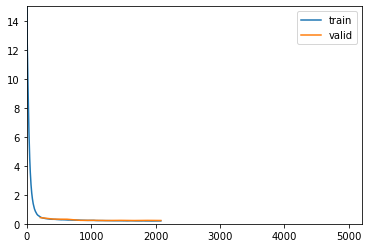

No improvement since epoch 5: early stopping


In [38]:
six_hour_model_final_hex7.fit(25,cbs=[ShowGraphCallback(),
                              EarlyStoppingCallback(monitor='valid_loss', 
                              min_delta=0.01, patience=5, reset_on_fit=True)])

In [141]:
prediction = six_hour_model_final_hex7.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  49.188 %
sMAPE:  36.869 %
MAE:  72.515
MSE:  86414.594
RMSE:  293.964
R2:  90.326 %
Max Residual Error:  7918.629


As expected we observe similar results as in the community area model. Since Hex 7 resolution covers roughly the same areas as community areas in Chicago. 

**Conculusion: Using Hex 7 geo attributes delivers similar result as using community areas in six hour model like the daily model**

### 6H Model - Hex 6
---
Lastly we change the geographic predictors from community areas to hexes with resolution 6. After training the model we compare the results with the community area model. Contrary to the hex 7 model we expect our result to change since the hex 6 resolution covers much bigger geographical areas. 
The model scores has improved in the daily model, thus we expect the same to occur in this model.

In [40]:
#Log transformation
six_hour_demand_hex_6['Demand (6H)'] = np.log(six_hour_demand_hex_6['Demand (6H)'])

In [41]:
#Train - Test - Validation Split
train_val_dls,test_dl = prediction_nn.split_data_sets_for_nn(six_hour_demand_hex_6,temporal_resolution='6H',
                                                test_size=0.2,batch_size=256,validation_size=0.2)

In [42]:
train_val_dls.items.head(5)

,hex_6_pickup,Demand (6H),Week,Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Hour,Elapsed
0,1,0.000000,1,1.326583,0.881452,-1.140731,0.695587,3.070901,2.203306,-0.916542,...,3,235,2,1,2,1,2,1,4,-1.725333
1,1,0.000000,1,1.326583,0.881452,-1.140731,0.695587,3.070901,2.203306,-0.916542,...,3,235,2,1,2,1,2,1,4,-1.725333
2,3,2.995732,1,1.326583,0.881452,-1.140731,0.695587,3.070901,0.774066,-1.012486,...,3,235,2,1,2,1,2,1,4,-1.725333
3,3,2.995732,1,1.326583,0.881452,-1.140731,0.695587,3.070901,0.774066,-1.012486,...,3,235,2,1,2,1,2,1,4,-1.725333
4,4,0.000000,1,1.326583,0.881452,-1.140731,0.695587,3.070901,1.225434,-0.989280,...,3,235,2,1,2,1,2,1,4,-1.725333


In [43]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(train_val_dls.cont_names)
print('\nCategorical variables:')
print(train_val_dls.cat_names)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['hex_6_pickup', 'Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Hour', 'Dayofyear', 'Week']


In [44]:
#Config Profile
y_range = [six_hour_demand_hex_6['Demand (6H)'].min(),six_hour_demand_hex_6['Demand (6H)'].max()*1.1]
config_final = tabular_config(ps=[0.001,0.1,0.01], embed_p=0.04, y_range=y_range, use_bn=True, 
               bn_final=False, bn_cont=True)
six_hour_model_final_hex6 = tabular_learner(train_val_dls, layers=[75,50,25],config=config_final,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True, moms=(0.95, 0.85, 0.95))

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,0.340904,0.268420,0.038935,0.737353,00:09
1,0.261474,0.241575,0.038132,0.766477,00:09
2,0.216300,0.202583,0.034427,0.605789,00:09
3,0.190850,0.203038,0.034037,0.624043,00:09
4,0.167132,0.198137,0.033251,0.586496,00:09
5,0.155716,0.201682,0.033218,0.568445,00:09
6,0.145298,0.201853,0.033199,0.620968,00:09
7,0.140772,0.194391,0.033281,0.596087,00:10


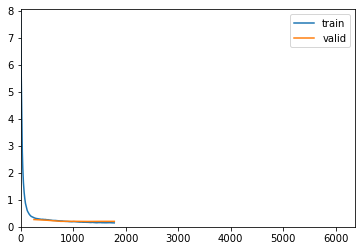

No improvement since epoch 2: early stopping


In [45]:
six_hour_model_final_hex6.fit(25,cbs=[ShowGraphCallback(),
                              EarlyStoppingCallback(monitor='valid_loss', 
                              min_delta=0.01, patience=5, reset_on_fit=True)])

In [46]:
prediction = six_hour_model_final_hex6.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  49.005 %
sMAPE:  34.645 %
MAE:  145.044
MSE:  287457.344
RMSE:  536.150
R2:  92.655 %
Max Residual Error:  9768.537


We see that using a bigger geographical areas led our model to generelize better. We should look only at the relative metrics (MAPE and sMAPE) since the absolute metrics increase regardless of how good the model performs, the reason being the increase in the aggregated demand in each hexagon in the underlying data.

**Conculusion: Using Hex 6 geo attributes delivers better result as using community areas as we saw the same effect on the daily model.**

In [47]:
#Memory Cleaning
del six_hour_demand
del six_hour_demand_hex_6
del six_hour_demand_hex_7

# Hourly Models
---
To help taxi companies prepare for hourly demand in different part of the city we build a hourly demand prediction model using neural networks. This model will help the cab industry to better utilize its resources within a day and is also beneficial for short term planning. The model is based on the 2015 inforamtion.

**Model input:**
- Geographical area where the customer is expected
- Date and Time
- Weather Information

**Model output:**
- Demand for the given date and time at the given area

## Data Preparation
---
First we aggregate and prepare our data for modeling.

In [48]:
# Takes few minutes to run (16 GB RAM)
chicago_df = utils.read_parquet('Taxi_Trips_Cleaned.parquet', 
                                columns=['Trip ID','Trip Start Timestamp','Pickup Community Area',
                                         'Dropoff Community Area'])
weather_df = utils.read_parquet('Weather.parquet',columns = ['Trip Start Timestamp','Humidity(%)',
                                    'Pressure(hPa)','Temperature(C)',
                                    'Wind Direction(Meteoro. Degree)','Wind Speed(M/S)'])

hourly_demand = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='H')
hourly_demand_hex_7 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='H',
                                            use_hexes=True,hex_resolution=7)
hourly_demand_hex_6 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='H',
                                            use_hexes=True,hex_resolution=6)

del chicago_df
del weather_df

### Feature Engineering
---
In this section we add the following spatial and temporal features to our data before prediction.
- Distance to Chicago City Center
- Distance to Chicago Airport
- Holiday Events

In [49]:
#Spatial Features
hourly_demand = feature_engineering.add_spatial_features(hourly_demand)
hourly_demand_hex_7 = feature_engineering.add_spatial_features(hourly_demand_hex_7,with_hex=7,hex_res=7)
hourly_demand_hex_6 = feature_engineering.add_spatial_features(hourly_demand_hex_6,with_hex=6,hex_res=6)
#Holidays
hourly_demand = feature_engineering.add_holidays(hourly_demand)
hourly_demand_hex_6 = feature_engineering.add_holidays(hourly_demand_hex_6)
hourly_demand_hex_7 = feature_engineering.add_holidays(hourly_demand_hex_7)

### Hourly Model - Community Areas
---
In this section we build our nn model for demand prediction using community areas.

### Model Architecture
---
To gain a better understanding of our data and the amount of complexity needed in the nn architecture we first start our hourly model by the last structure used in our six hour models. We also use the last configurations regarding the regularization parameters. After observing the behavoiur of the model with our hourly data, we adjust (if necessary) the layer structures and hyper parameters of our model. 

_Note: This was an iterative process. We didn't use brut force algorithms to search for the optimal structure on a grid as it is not computationaly feasible._

### Suitable Metrics
---
Like the last two models we plot the target distribution to check which metrics we should apply to our ML problem.

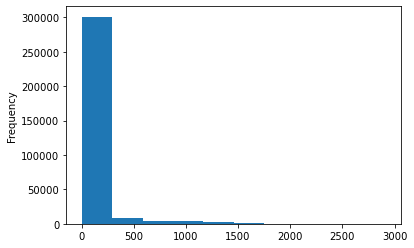

In [7]:
hourly_demand['Demand (H)'].plot.hist()
plt.show()

As we expected the target is extremely skewed like the daily and 6H model. Which would make the prediction metrics non telling. Thus as before we transform the target logarithmically. Mean squared logarithmic error will be used as a suitable metric.

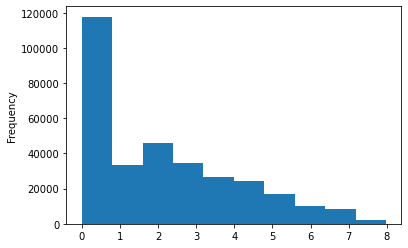

In [8]:
#Log Transforamtion
hourly_demand['Demand (H)'] = np.log(hourly_demand['Demand (H)'])
hourly_demand['Demand (H)'].plot.hist()
plt.show()

In [50]:
#Train - Test - Validation Split
train_val_dls,test_dl = prediction_nn.split_data_sets_for_nn(hourly_demand,temporal_resolution='H',
                                                test_size=0.2,batch_size=256,validation_size=0.2)

In [10]:
train_val_dls.items.head(5)

,Pickup Community Area,Demand (H),Week,Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Hour,Elapsed
0,1,3.178054,1,1.281646,1.008329,-1.142306,0.608084,2.530656,0.857106,0.993790,...,4,1,1,2,1,2,1,2,1,-1.717747
1,2,0.000000,1,1.281646,1.008329,-1.142306,0.608084,2.530656,1.647908,0.985921,...,4,1,1,2,1,2,1,2,1,-1.717747
2,3,1.386294,1,1.281646,1.008329,-1.142306,0.608084,2.530656,1.162746,0.988592,...,4,1,1,2,1,2,1,2,1,-1.717747
3,5,1.386294,1,1.281646,1.008329,-1.142306,0.608084,2.530656,0.723733,0.991644,...,4,1,1,2,1,2,1,2,1,-1.717747
4,6,2.708050,1,1.281646,1.008329,-1.142306,0.608084,2.530656,0.441559,0.992789,...,4,1,1,2,1,2,1,2,1,-1.717747


In [51]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(train_val_dls.cont_names)
print('\nCategorical variables:')
print(train_val_dls.cat_names)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['Pickup Community Area', 'Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Hour', 'Dayofyear', 'Week']


#### NN Model Hourly - First Iteration
---
We first use all of the regularization paramter used in the daily model config (we have checked for the learning rate using the cyclical method as before) and tune them by observing the model behaviour. The Parameters:

- Network Architecture: 75 x 50 x 25
- Embedding Dropout Probability: 7%
- Continous Dropout Probability: 0.1% in the first layer and 1% in the hidden layers
- Learning rate: 0.001
- Momentum: 0.95 - 0.85 - 0.95 (adaptive)
- Batch Normalization for input/Hidden layers
- Loss Function: MSE
- Target: Logarithmic Daily Demand
- Early Stopping: If no imporvement better than 0.01 (after maximum 5 epochs)

In [13]:
#Config Profile
y_range = [hourly_demand['Demand (H)'].min(),hourly_demand['Demand (H)'].max()*1.1]
config_first_iter = tabular_config(ps=[0.001,0.01,0.01], embed_p=0.07, y_range=y_range, use_bn=True, 
               bn_final=False, bn_cont=True)
hourly_model_first_iter = tabular_learner(train_val_dls, layers=[75,50,25],config=config_first_iter,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True, moms=(0.95, 0.85, 0.95))

In [18]:
hourly_model_first_iter.summary()

TabularModel (Input shape: 256 x torch.Size([256, 8]))
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 18            
Embedding                                 1404       True      
____________________________________________________________________________
                     256 x 3             
Embedding                                 9          True      
____________________________________________________________________________
                     256 x 2             
Embedding                                 4          True      
____________________________________________________________________________
                     256 x 5             
Embedding                                 45         True      
____________________________________________________________________________
                     256 x 11            
Embedding                                 352        True      
___________________________________________

#### Suitable learning rate
---
To find the best learning rate we make use of the lr_find function of the fast ai library. For in depth information please refer to this paper: 
_Cyclical Learning Rates for Training Neural Networks by Leslie N. Smith_

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=1.3182567499825382e-06)

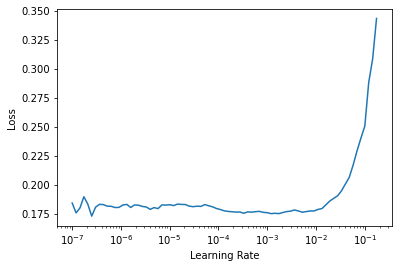

In [17]:
hourly_model_first_iter.lr_find()

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,0.261234,0.241838,0.059516,0.767131,00:29
1,0.225499,0.217555,0.054735,0.723308,00:29
2,0.202722,0.218535,0.055755,0.734148,00:29
3,0.193837,0.214191,0.054147,0.726189,00:29
4,0.189952,0.216557,0.054807,0.733725,00:30
5,0.188963,0.212230,0.055065,0.731536,00:29
6,0.186797,0.226481,0.054971,0.911463,00:29


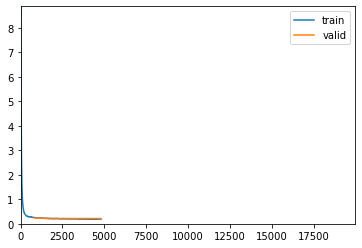

No improvement since epoch 1: early stopping


In [15]:
hourly_model_first_iter.fit(25,cbs=[ShowGraphCallback(),
                              EarlyStoppingCallback(monitor='valid_loss', 
                              min_delta=0.01, patience=5, reset_on_fit=True)])

In [16]:
prediction = hourly_model_first_iter.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  56.966 %
sMAPE:  37.820 %
MAE:  25.186
MSE:  8227.054
RMSE:  90.703
R2:  78.236 %
Max Residual Error:  1703.532


The result of our first iteration are not bad. Although by looking at the R2 metric we see that an increase in the number of nodes will be beneficial so that the model is capture to more of the underlying variance.

#### NN Model Hourly - Final
---
- Network Architecture: 200 x 100
- L2 Regularization: 0.001
- Embedding Dropout Probability: 4%
- Continous Dropout Probability: 0.1% in the first layer and 1% in the hidden layer
- Learning rate: 0.001
- Momentum: 0.95 - 0.85 - 0.95 (adaptive)
- Batch Normalization for input/Hidden layers
- Loss Function: MSE
- Target: Logarithmic Daily Demand
- Early Stopping: If no imporvement better than 0.01 (after maximum 5 epochs)

In [44]:
#Config Profile
y_range = [hourly_demand['Demand (H)'].min(),hourly_demand['Demand (H)'].max()*1.1]
config_final = tabular_config(ps=[0.001,0.01], embed_p=0.04, y_range=y_range, use_bn=True, 
               bn_final=False, bn_cont=True)
hourly_model_final = tabular_learner(train_val_dls, layers=[200,100],config=config_final,wd=0.001,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True, moms=(0.95, 0.85, 0.95))

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,0.227577,0.228357,0.055944,0.720135,00:31
1,0.196527,0.210550,0.054527,0.689679,00:30
2,0.185409,0.208655,0.054425,0.657161,00:30
3,0.183302,0.214817,0.055769,0.727281,00:30
4,0.173124,0.204735,0.054891,0.713364,00:31
5,0.174509,0.204643,0.054041,0.691839,00:31
6,0.166050,0.202774,0.053748,0.741349,00:30


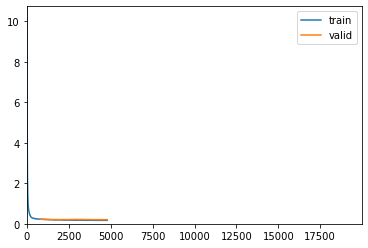

No improvement since epoch 1: early stopping


In [45]:
hourly_model_final.fit(25,cbs=[ShowGraphCallback(),
                              EarlyStoppingCallback(monitor='valid_loss', 
                              min_delta=0.01, patience=5, reset_on_fit=True)])

In [40]:
prediction = hourly_model_final.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  48.916 %
sMAPE:  35.539 %
MAE:  17.531
MSE:  3791.274
RMSE:  61.573
R2:  89.971 %
Max Residual Error:  1492.383


As expected the model score has improved significantly by adding the number nodes in the first and second laywer and removing the third hidden layer and simultaneously adding more regularization to the model to avoid overfitting. Variance of the underlying data could be captured better by this model hence the R2 metric has increased from 78% to almost 90%.

### Hourly Model - Hex 7
---
After finding the suitable model architecture for hourly demand prediction we change the geographic predictors from community areas to hexes with resolution 7. After training the model we compare the results with the community area model. We expect to observe similiar results like the daily and 6H model.

In [52]:
#Log transformation
hourly_demand_hex_7['Demand (H)'] = np.log(hourly_demand_hex_7['Demand (H)'])

In [53]:
#Train - Test - Validation Split
train_val_dls,test_dl = prediction_nn.split_data_sets_for_nn(hourly_demand_hex_7,temporal_resolution='H',
                                                test_size=0.2,batch_size=256,validation_size=0.2)

In [54]:
train_val_dls.items.head(5)

,hex_7_pickup,Demand (H),Week,Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Hour,Elapsed
0,4,1.945910,1,1.283532,1.007035,-1.145907,0.608768,2.52647,1.107388,0.999534,...,4,1,1,2,1,2,1,2,1,-1.718037
1,11,0.000000,1,1.283532,1.007035,-1.145907,0.608768,2.52647,1.823253,1.015066,...,4,1,1,2,1,2,1,2,1,-1.718037
2,13,6.100319,1,1.283532,1.007035,-1.145907,0.608768,2.52647,-1.260513,1.001353,...,4,1,1,2,1,2,1,2,1,-1.718037
3,14,6.501290,1,1.283532,1.007035,-1.145907,0.608768,2.52647,-0.464913,0.998380,...,4,1,1,2,1,2,1,2,1,-1.718037
4,15,6.182085,1,1.283532,1.007035,-1.145907,0.608768,2.52647,-1.768029,1.004327,...,4,1,1,2,1,2,1,2,1,-1.718037


In [55]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(train_val_dls.cont_names)
print('\nCategorical variables:')
print(train_val_dls.cat_names)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Hour', 'Dayofyear', 'Week', 'hex_7_pickup']


In [51]:
#Config Profile
y_range = [hourly_demand_hex_7['Demand (H)'].min(),hourly_demand_hex_7['Demand (H)'].max()*1.1]
config_final = tabular_config(ps=[0.001,0.01], embed_p=0.04, y_range=y_range, use_bn=True, 
               bn_final=False, bn_cont=True)
hourly_model_final_hex7 = tabular_learner(train_val_dls, layers=[200,100],config=config_final,wd=0.001,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True, moms=(0.95, 0.85, 0.95))

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,0.218169,0.239326,0.055626,0.773210,00:31
1,0.192973,0.217713,0.052987,0.672423,00:32
2,0.180812,0.206686,0.053343,0.685038,00:31
3,0.176005,0.216246,0.054190,0.741565,00:31
4,0.166313,0.223264,0.052769,0.823091,00:31
5,0.167422,0.207402,0.051196,0.681231,00:32
6,0.164722,0.214683,0.051930,0.727079,00:32
7,0.163951,0.212465,0.051099,0.678409,00:33


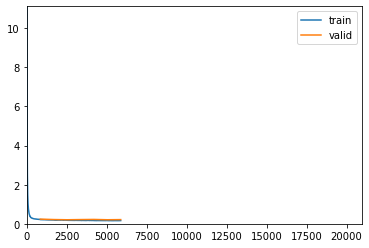

No improvement since epoch 2: early stopping


In [52]:
hourly_model_final_hex7.fit(25,cbs=[ShowGraphCallback(),
                              EarlyStoppingCallback(monitor='valid_loss', 
                              min_delta=0.01, patience=5, reset_on_fit=True)])

In [53]:
prediction = hourly_model_final_hex7.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  48.491 %
sMAPE:  35.974 %
MAE:  17.686
MSE:  3937.809
RMSE:  62.752
R2:  89.075 %
Max Residual Error:  1411.583


As it was the case in daily and 6H model, we observe similar results. Since Hex 7 resolution covers roughly the same areas as community areas do in Chicago. 

**Conculusion: Using Hex 7 geo attributes delivers similar result as using community areas in hourly model like the last two models (daily, 6H)**

### Hourly Model - Hex 6
---
At our last step we change the geographic predictors from community areas to hexes with resolution 6. After training the model we compare the results with the community area model. Contrary to the hex 7 model we expect our result to change since the hex 6 resolution covers much bigger geographical areas. 

In [56]:
#Log transformation
hourly_demand_hex_6['Demand (H)'] = np.log(hourly_demand_hex_6['Demand (H)'])

In [57]:
#Train - Test - Validation Split
train_val_dls,test_dl = prediction_nn.split_data_sets_for_nn(hourly_demand_hex_6,temporal_resolution='H',
                                                test_size=0.2,batch_size=256,validation_size=0.2)

In [58]:
train_val_dls.items.head(5)

,hex_6_pickup,Demand (H),Week,Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Hour,Elapsed
0,3,1.94591,1,1.28676,0.921398,-1.161807,0.6109,2.519888,0.948472,-1.005768,...,4,1,1,2,1,2,1,2,1,-1.725305
1,3,1.94591,1,1.28676,0.921398,-1.161807,0.6109,2.519888,0.948472,-1.005768,...,4,1,1,2,1,2,1,2,1,-1.725305
2,5,0.00000,1,1.28676,0.921398,-1.161807,0.6109,2.519888,2.115504,-0.952771,...,4,1,1,2,1,2,1,2,1,-1.725305
3,5,0.00000,1,1.28676,0.921398,-1.161807,0.6109,2.519888,2.115504,-0.952771,...,4,1,1,2,1,2,1,2,1,-1.725305
4,5,0.00000,1,1.28676,0.921398,-1.161807,0.6109,2.519888,2.115504,-0.952771,...,4,1,1,2,1,2,1,2,1,-1.725305


In [59]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(train_val_dls.cont_names)
print('\nCategorical variables:')
print(train_val_dls.cat_names)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['hex_6_pickup', 'Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Hour', 'Dayofyear', 'Week']


In [60]:
#Config Profile
y_range = [hourly_demand_hex_6['Demand (H)'].min(),hourly_demand_hex_6['Demand (H)'].max()*1.1]
config_final = tabular_config(ps=[0.01,0.01], embed_p=0.04, y_range=y_range, use_bn=True, 
               bn_final=False, bn_cont=True)
hourly_model_final_hex6 = tabular_learner(train_val_dls, layers=[200,100],config=config_final,wd=0.001,
                n_out=1, opt_func=Adam,loss_func=F.mse_loss, lr=0.001,
                metrics=[msle,exp_rmspe],
                train_bn=True, moms=(0.95, 0.85, 0.95))

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,0.182151,0.222895,0.052101,0.814958,00:48
1,0.162096,0.204972,0.051390,0.725413,00:51
2,0.148794,0.199888,0.049785,0.645718,00:51
3,0.145047,0.202226,0.050066,0.688501,00:50
4,0.133562,0.201049,0.050718,0.702644,00:49
5,0.131473,0.209377,0.050629,0.716973,00:49
6,0.128455,0.206676,0.050893,0.763854,00:51


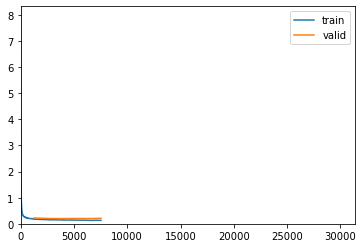

No improvement since epoch 1: early stopping


In [58]:
hourly_model_final_hex6.fit(25,cbs=[ShowGraphCallback(),
                              EarlyStoppingCallback(monitor='valid_loss', 
                              min_delta=0.01, patience=5, reset_on_fit=True)])

epoch,train_loss,valid_loss,msle,_exp_rmspe,time
0,0.186378,0.210866,0.051340,0.689379,00:47
1,0.166970,0.211917,0.052192,0.805577,00:48
2,0.151557,0.204947,0.050453,0.678767,00:48
3,0.145918,0.197686,0.050037,0.627754,00:48
4,0.143523,0.196960,0.050847,0.670852,00:48
5,0.139619,0.202198,0.051084,0.725575,00:48
6,0.132956,0.200465,0.049741,0.645943,00:48
7,0.129137,0.210879,0.050800,0.694170,00:49
8,0.126453,0.211285,0.051991,0.794365,00:48


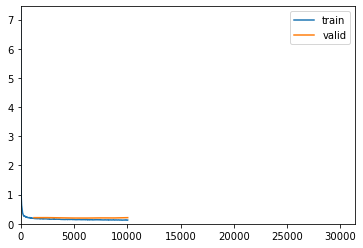

No improvement since epoch 3: early stopping


In [61]:
hourly_model_final_hex6.fit(25,cbs=[ShowGraphCallback(),
                              EarlyStoppingCallback(monitor='valid_loss', 
                              min_delta=0.01, patience=5, reset_on_fit=True)])

In [62]:
prediction = hourly_model_final_hex6.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=np.exp(prediction[1]),
                                       y_predicted=np.exp(prediction[0]), s_mape=True)

-------MODEL SCORES-------
MAPE:  50.245 %
sMAPE:  35.553 %
MAE:  30.658
MSE:  13837.097
RMSE:  117.631
R2:  90.220 %
Max Residual Error:  2553.892


We see that using a bigger geographical areas helped our model to generelize better like in the last two cases (Daily, 6H). Again as before we should look only at the relative metrics (MAPE and sMAPE) since the absolute metrics increase regardless of how good the model performs, the reason being the increase in the aggregated demand in each hexagon in the underlying data. In this case the MAPE metric is also biased because of many near zero hourly demand. The MAPE metric gives a high penalty for prediction errors accuring in this cases. Thus we look only at the sMAPE metric as it is the usual relative metrics used in spatio temporal modeling and is used excessively in the papers in this field.

**Conculusion: Using Hex 6 geo attributes delivers better result as using community areas as we saw previously.**

In [63]:
#Memory Cleaning
del hourly_demand
del hourly_demand_hex_6
del hourly_demand_hex_7

## NN Result Analysis
---


## Overall Scores & Outlook
---